In [1]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod
 
xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [3]:
season = 'MAM'

### Filename for saved plots

In [4]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [5]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [6]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [7]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [8]:
from bs_fdbck.constants import path_measurement_data

## Settings: 

In [9]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [10]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

In [11]:
ds_smr_sat = xr.open_dataset(sat_filename)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [12]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 ...
Data variables: (12/20)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    N50-500                                     (time) float64 ...
    N100-500                                    (time) float64 ...
    N200-500                                    (time) float64 ...
    BC_conc                                     (time) float64 ...
    day_of_year                                 (time) float64 ...
    hour                                        (time) float64 ...

In [13]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [14]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

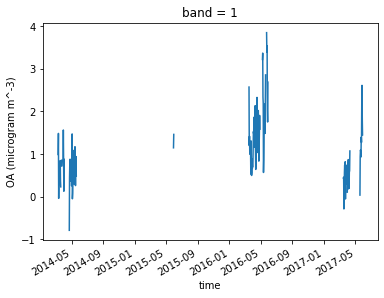

In [15]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [16]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([0.67705491, 1.25726987])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

## *MASK BY BC: 

In [17]:
ds_smr_sat_JA['OA (microgram m^-3)'].count()

<xarray.DataArray 'OA (microgram m^-3)' ()>
array(148)
Coordinates:
    band     int64 1

In [18]:
ds_smr_sat_JA = ds_smr_sat_JA.where(ds_smr_sat_JA['BC_conc'].fillna(0)<.05)

In [19]:
ds_smr_sat_JA['OA (microgram m^-3)'].count()

<xarray.DataArray 'OA (microgram m^-3)' ()>
array(94)
Coordinates:
    band     int64 1

In [20]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([0.56148253, 0.94249929])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

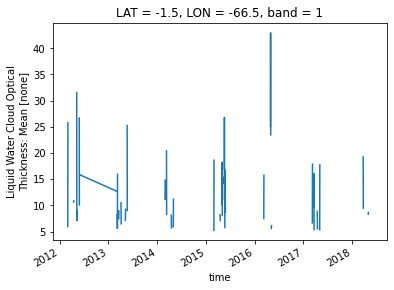

In [21]:
ds_smr_sat_JA['COT'].isel(LAT=0,LON=0).plot()

In [22]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

In [23]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [24]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 644, LAT: 7, LON: 15)
Coordinates:
  * time                 (time) datetime64[ns] 2012-03-01 ... 2018-05-31
  * LAT                  (LAT) float64 -1.5 -2.5 -3.5 -4.5 -5.5 -6.5 -7.5
  * LON                  (LON) float64 -66.5 -65.5 -64.5 ... -54.5 -53.5 -52.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 nan nan nan ... nan nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 nan 277.0 nan ... 67.0 nan nan
    CER (micrometer)     (time, LAT, LON) float32 nan 22.87 nan ... nan nan
    COT                  (time, LAT, LON) float32 nan 18.43 nan ... nan nan

In [25]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [26]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [27]:
df_smr_sat_JAs#.dropna()

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       LAT  LON                                                          
2014-03-12 -1.5 -66.5             -0.04000         289.0         22.750000   
           -2.5 -66.5             -0.04000         122.0         21.939999   
                -65.5             -0.04000         155.0         23.500000   
           -3.5 -53.5             -0.04000         124.0         23.959999   
                -52.5             -0.04000         175.0         21.449999   
...                                    ...           ...               ...   
2017-05-30 -7.5 -56.5              1.45007         219.0         19.920000   
                -55.5              1.45007         249.0         20.299999   
                -54.5              1.45007         305.0         21.049999   
                -53.5              1.45007         323.0         19.820000   
                -52.5              1.45007         338.0         22.389999   

                             COT  
time       LAT  LON               
2014-03-12 -1.5 -66.5  20.420000  
           -2.5 -66.5   9.610000  
                -65.5  10.050000  
           -3.5 -53.5   7.990000  
                -52.5  12.280000  
...                          ...  
2017-05-30 -7.5 -56.5  16.190001  
                -55.5  17.389999  
                -54.5  23.379999  
                -53.5  25.309999  
                -52.5  24.309999  

[3169 rows x 4 columns]

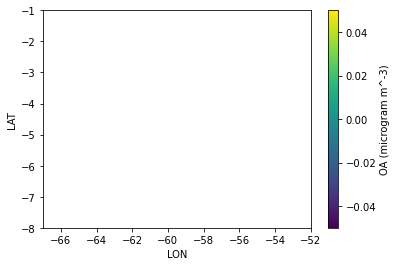

In [28]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [29]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [30]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


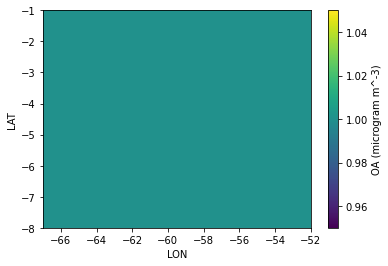

In [31]:
(~da_drop_pixels).plot()

In [32]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

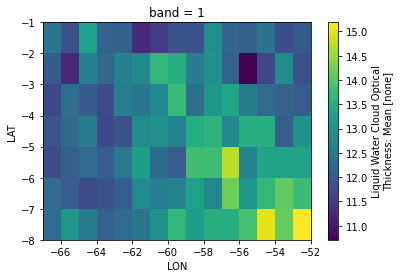

In [33]:
ds_smr_sat_JAs['COT'].mean('time').plot()

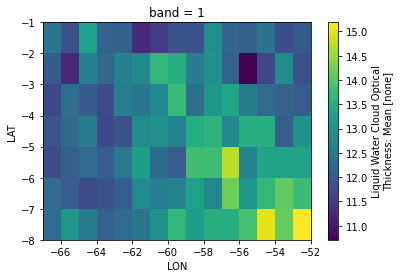

In [34]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([ 105.,  105.,  735., 2310., 2940., 1470.,  945.,  630.,  420.,
         210.]),
 array([-0.79      , -0.45369975, -0.1173995 ,  0.21890075,  0.555201  ,
         0.89150125,  1.2278015 ,  1.56410175,  1.900402  ,  2.23670225,
         2.5730025 ]),
 <BarContainer object of 10 artists>)

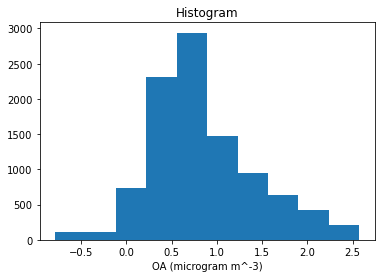

In [35]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [36]:
dic_OA_percentiles = dict()

In [37]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [38]:
df_hyy_1

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       lat  lon                                                          
2012-03-01 -7.5 -66.5                  NaN         211.0             22.23   
2012-03-02 -7.5 -66.5                  NaN           NaN               NaN   
2012-03-03 -7.5 -66.5                  NaN           NaN               NaN   
2012-03-04 -7.5 -66.5                  NaN           NaN               NaN   
2012-03-05 -7.5 -66.5                  NaN           NaN               NaN   
...                                    ...           ...               ...   
2018-05-27 -1.5 -52.5                  NaN           NaN               NaN   
2018-05-28 -1.5 -52.5                  NaN           NaN               NaN   
2018-05-29 -1.5 -52.5                  NaN           NaN               NaN   
2018-05-30 -1.5 -52.5                  NaN           NaN               NaN   
2018-05-31 -1.5 -52.5                  NaN         155.0             17.24   

                             COT  
time       lat  lon               
2012-03-01 -7.5 -66.5  14.690000  
2012-03-02 -7.5 -66.5        NaN  
2012-03-03 -7.5 -66.5        NaN  
2012-03-04 -7.5 -66.5        NaN  
2012-03-05 -7.5 -66.5        NaN  
...                          ...  
2018-05-27 -1.5 -52.5        NaN  
2018-05-28 -1.5 -52.5        NaN  
2018-05-29 -1.5 -52.5        NaN  
2018-05-30 -1.5 -52.5        NaN  
2018-05-31 -1.5 -52.5  13.719999  

[67620 rows x 4 columns]

df_smr_sat_JAsad model data:

## Load model data

In [39]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth' 

models =[model_name_noresm,model_name_echam,model_name_ec_earth]

### Settings

In [40]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

In [41]:
l=-10
((l)%360)

350

In [42]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

In [43]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

### NorESM

In [44]:


lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

In [45]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [46]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files created in [02-create_file-long_sum.ipynb](02-create_file-long_sum)

#### Input files

In [47]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [48]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [49]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [50]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [51]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [52]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [53]:
cases_echam = [case_name_echam]

### EC-Earth

In [54]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [55]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [56]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [57]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [58]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [59]:
cases_ec_earth = [case_name_ec_earth]

### Read in model data

In [60]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2],parse_dates=[0] )
df_mod_noresm['month'] =df_mod_noresm.index.get_level_values(0).month
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_echam['month'] =df_mod_echam.index.get_level_values(0).month
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ec_earth['month'] =df_mod_ec_earth.index.get_level_values(0).month



In [61]:
df_mod_ec_earth.to_xarray()

<xarray.Dataset>
Dimensions:                   (time: 2558, lat: 10, lon: 22)
Coordinates:
  * time                      (time) datetime64[ns] 2011-12-31 ... 2018-12-31
  * lat                       (lat) float64 -7.37 -6.67 -5.96 ... -1.75 -1.05
  * lon                       (lon) float64 293.2 293.9 294.6 ... 307.3 308.0
Data variables: (12/107)
    station                   (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO'
    cc_cltop                  (time, lat, lon) float64 nan nan nan ... nan nan
    r_eff                     (time, lat, lon) float64 nan nan nan ... nan nan
    tcwv                      (time, lat, lon) float64 nan nan nan ... nan nan
    CWP                       (time, lat, lon) float64 nan nan nan ... nan nan
    ttc                       (time, lat, lon) float64 nan nan nan ... nan nan
    ...                        ...
    DDRY_COS                  (time, lat, lon) float64 nan nan ... 522.2 522.2
    M_BCCOS                   (time, lat, lon) float64 nan nan ... 1.961e-14
    CCN1.00                   (time, lat, lon) float64 nan nan ... 272.0 272.0
    M_DUCOI                   (time, lat, lon) float64 nan nan ... 2.493e-09
    N_ACI                     (time, lat, lon) float64 nan nan ... 5.423 5.423
    year                      (time, lat, lon) int64 2011 2011 ... 2018 2018

## Pick out months:

In [62]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]

<AxesSubplot:ylabel='Frequency'>

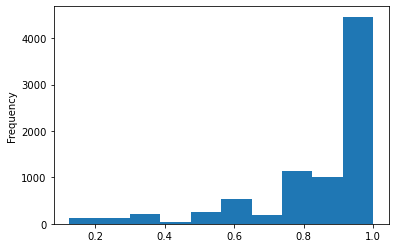

In [63]:
df_mod_echam['cl_time_ct'].plot.hist()

### Organize data in dictionary

In [64]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df['Observations'] = df_hyy_1



### *Scale CWP down for EC-Earth

In [65]:
_df = dic_df[model_name_ec_earth]
_df = _df.rename({'CWP':'CWP_orig'}, axis=1)
dic_df[model_name_ec_earth]  = _df

In [66]:
_df = dic_df[model_name_ec_earth]

if 'scaled' not in _df.columns:
    _df['CWP'] = _df['CWP_orig']*.7
    
    _df['scaled'] = True
    print('scaling CWP in EC-Earth')
dic_df[model_name_ec_earth]  = _df

scaling CWP in EC-Earth


<AxesSubplot:ylabel='Frequency'>

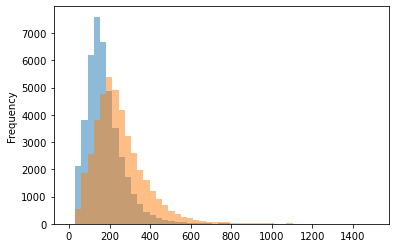

In [67]:
dic_df[model_name_ec_earth]['CWP'].plot.hist(alpha=.5, bins=np.linspace(0,1500))
dic_df[model_name_ec_earth]['CWP_orig'].plot.hist(alpha=.5, bins=np.linspace(0,1500))

## Check everythign is fine:

In [68]:
for mod in dic_df.keys():
    print(dic_df[mod].to_xarray())

<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-03-01 2012-03-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/51)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    lcdnc_ct        (time, lat, lon) float64 nan nan nan ... nan nan nan
    cod_incld       (time, lat, lon) float64 nan nan nan 13.39 ... nan nan nan
    lcdnc           (time, lat, lon) float64 nan nan nan ... nan nan nan
    cwp             (time, lat, lon) float64 nan nan nan 75.2 ... nan nan nan
    ...              ...
    N200            (time, lat, lon) float64 9.052 9.554 6.578 ... 34.16 33.29
    N50             (time, lat, lon) float64 30.89 44.01 52.22 ... 249.2 254.9
    T               (time, lat, lon) float6

## Rename variables:


<AxesSubplot:ylabel='Frequency'>

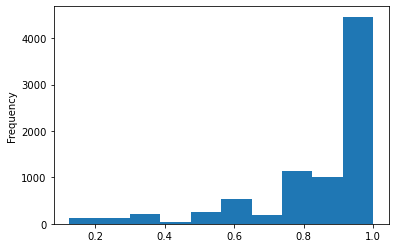

In [69]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [70]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',
    

}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
    'OA_STP':'OA',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}
rn_dic_ec_earth = {
    'OA_STP':'OA',
}

In [71]:
model2rndic = {
    model_name_noresm : rn_dic_noresm,
    model_name_ec_earth: rn_dic_ec_earth,
    model_name_echam:rn_dic_echam,
    'Observations': rn_dic_obs
}

#### Fix NorESM having OA as well as OA_STP

In [72]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'Observations'])

In [73]:
for mod in models+ ['Observations']:
    _rn_dic = model2rndic[mod]
    if ('OA' in dic_df[mod].columns) & ('OA_STP' in dic_df[mod].columns):
        if ('OA_STP' in _rn_dic):
            if (_rn_dic['OA_STP']=='OA'):
                dic_df[mod] = dic_df[mod].drop(['OA'], axis=1)
                print('dropping OA in favor of OA_STP')
    dic_df[mod] = dic_df[mod].rename(_rn_dic, axis=1)

dropping OA in favor of OA_STP


In [74]:
for mod in dic_df.keys():
    print(mod)
    print(dic_df[mod].to_xarray())

ECHAM-SALSA
<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-03-01 2012-03-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/51)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    lcdnc_ct        (time, lat, lon) float64 nan nan nan ... nan nan nan
    cod_incld       (time, lat, lon) float64 nan nan nan 13.39 ... nan nan nan
    lcdnc           (time, lat, lon) float64 nan nan nan ... nan nan nan
    cwp             (time, lat, lon) float64 nan nan nan 75.2 ... nan nan nan
    ...              ...
    N200            (time, lat, lon) float64 9.052 9.554 6.578 ... 34.16 33.29
    N50             (time, lat, lon) float64 30.89 44.01 52.22 ... 249.2 254.9
    T               (time, lat,

<AxesSubplot:ylabel='Frequency'>

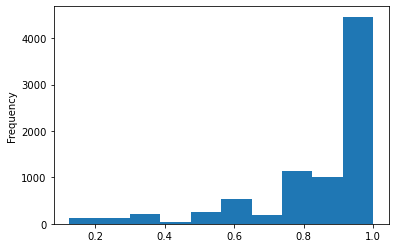

In [75]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

## Group by cloud water path 

#### Predefined bins

In [76]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins['Observations'] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])




## Mask data

### moved to pre-processing: NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top

df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

### Bin model data:

CWP above 50. 

In [77]:
varl_categories = ['OA']#,'CLDFREE'

In [78]:
varlist_notna = ['OA','CWP','COT','r_eff']
varlist_notna_noCOT = set(varlist_notna)-set(['COT'])

In [79]:
dic_df['EC-Earth']['N100-500_STP']

time        lat    lon   
2012-03-01  -7.37  293.20    239.569378
                   293.91    239.569378
                   294.61    239.569378
                   295.31    239.569378
                   296.02    239.569378
                                ...    
2018-05-31  -1.05  305.16    507.199523
                   305.86    507.199523
                   306.56    507.199523
                   307.27    507.199523
                   307.97    507.199523
Name: N100-500_STP, Length: 141680, dtype: float64

In [80]:
dic_df.keys()
ds_ec = dic_df['EC-Earth'].to_xarray()

In [81]:
a = dic_df['NorESM'].T.duplicated()

In [82]:
a.index

Index(['station', 'FSNT', 'ACTNL', 'TOT_ICLD_VISTAU', 'FLNTCDRF',
       'optical_depth', 'FSNSC', 'FSUTADRF', 'FLNS', 'CLDTOT', 'COT',
       'TOT_CLD_VISTAU', 'FLNT', 'FSDS_DRF', 'FSUS_DRF', 'FSNTCDRF',
       'TGCLDLWP', 'TGCLDIWP', 'FLNSC', 'FLUS', 'transmittance', 'FLUTC',
       'CLDFREE', 'TGCLDCWP', 'r_eff', 'FCTI', 'TOT_ICLD_VISTAU_s', 'ACTREL',
       'FREQL', 'FREQI', 'CWP', 'FLNT_DRF', 'FSDSCDRF', 'FSNT_DRF', 'FSNS',
       'TOT_CLD_VISTAU_s', 'TGCLDCWP_incld', 'FCTL', 'month', 'ismonth1',
       'ismonth2', 'ismonth3', 'ismonth4', 'ismonth5', 'ismonth6', 'ismonth7',
       'ismonth8', 'ismonth9', 'ismonth10', 'ismonth11', 'ismonth12', 'isJuly',
       'isAug', 'isJA', 'isSummer', 'ilev', 'lev', 'DST_A3', 'DOD500',
       'SO4_NA', 'BC_A', 'FORMRATE', 'OM_AC', 'N200_STP', 'SS_A3', 'PS', 'SOA',
       'BC_NI', 'DOD440', 'COAGNUCL', 'BC_AC', 'SO4_AC', 'OA', 'N100_STP',
       'SS_A1', 'SFisoprene', 'NCONC01', 'SOA_A1', 'BC_AI', 'DST_A2', 'OM_NI',
       'T', 'SFmonoterp', 'SS

In [83]:
ds_no = dic_df['NorESM'].to_xarray()

In [84]:
dic_df[model_name_echam]

station  lcdnc_ct_cm3    lcdnc_ct  cod_incld  \
time       lat       lon                                                    
2012-03-01 -2.797890 294.375    ATTO     11.517762  11517762.0   9.730782   
                     296.250    ATTO     12.082354  12082354.0   5.477490   
                     298.125    ATTO           NaN         NaN        NaN   
                     300.000    ATTO      1.301715   1301715.2  10.303343   
                     301.875    ATTO      0.593582    593582.2   8.521373   
...                              ...           ...         ...        ...   
2018-05-31 -6.528409 300.000    ATTO           NaN         NaN        NaN   
                     301.875    ATTO           NaN         NaN        NaN   
                     303.750    ATTO           NaN         NaN        NaN   
                     305.625    ATTO           NaN         NaN        NaN   
                     307.500    ATTO     44.569847  44569850.0  12.150103   

                                     lcdnc        cwp  clfr  tempair_ct  \
time       lat       lon                                                  
2012-03-01 -2.797890 294.375  3.659215e-29  196.35959   0.0   278.98807   
                     296.250  4.430445e-29   88.27257   0.0   282.87240   
                     298.125           NaN        NaN   NaN         NaN   
                     300.000  2.426875e-29  114.58487   0.0   276.29666   
                     301.875 -2.671051e-29   85.05574   0.0   267.30865   
...                                    ...        ...   ...         ...   
2018-05-31 -6.528409 300.000           NaN        NaN   NaN         NaN   
                     301.875           NaN        NaN   NaN         NaN   
                     303.750           NaN        NaN   NaN         NaN   
                     305.625           NaN        NaN   NaN         NaN   
                     307.500  9.468250e-29   84.10326   0.0   283.24900   

                                    COT  cl_time_ct  ...  emi_isop_bio  \
time       lat       lon                             ...                 
2012-03-01 -2.797890 294.375   9.730782       0.875  ...  9.785284e-10   
                     296.250   5.477490       0.625  ...  1.333748e-09   
                     298.125        NaN         NaN  ...  5.306542e-10   
                     300.000  10.303343       1.000  ...  6.202812e-10   
                     301.875   8.521373       0.750  ...  0.000000e+00   
...                                 ...         ...  ...           ...   
2018-05-31 -6.528409 300.000        NaN         NaN  ...  1.769491e-09   
                     301.875        NaN         NaN  ...           NaN   
                     303.750        NaN         NaN  ...  6.795642e-10   
                     305.625        NaN         NaN  ...           NaN   
                     307.500  12.150103       1.000  ...  7.864150e-10   

                              emi_monot_bio     mmrtrN50        N100  \
time       lat       lon                                               
2012-03-01 -2.797890 294.375   1.653002e-10  145743155.0   76.361270   
                     296.250   2.251881e-10  145743155.0   30.578302   
                     298.125   3.188332e-10  145743155.0   34.619812   
                     300.000   2.389973e-10  145743155.0   53.377760   
                     301.875   0.000000e+00  145743155.0   34.090100   
...                                     ...          ...         ...   
2018-05-31 -6.528409 300.000   1.789390e-10  217856110.0   96.088820   
                     301.875            NaN  217856110.0         NaN   
                     303.750   1.966801e-10  217856110.0  215.774670   
                     305.625            NaN  217856110.0         NaN   
                     307.500   1.924185e-10  217856110.0  191.381770   

                                   N200         N50          T      ORG_mass  \
time       lat       lon                                               

In [85]:
n_bins = 7

for model_name in dic_df.keys():

    print(model_name)
    df_mod = dic_df[model_name].copy()
    ## drop nans:
    if model_name =='EC-Earth':
        _vl = varlist_notna_noCOT
    else:
        _vl = varlist_notna
    df_mod = df_mod[df_mod[_vl].notna().all(axis=1)]


    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)

        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        if v=='OA':
            dic_OA_percentiles[model_name]=dict()
            dic_OA_percentiles[model_name]['33rd']=q34
            dic_OA_percentiles[model_name]['66th']=q66
            dic_OA_percentiles[model_name]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_OA_percentiles[model_name]['med_low']= df_mod[v][df_mod[v]<q34].median()


        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( q34<df_mod[v]) & (df_mod[v]<q66)
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.95])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)
 
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    dic_df[model_name] = df_mod

ECHAM-SALSA
0.6472832
1.4296297
NorESM
4.694496238558584
7.745165701784893
EC-Earth


/tmp/ipykernel_83151/3884036908.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].notna().all(axis=1)]
/tmp/ipykernel_83151/3884036908.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_low'] = df_mod[v]<q34
/tmp/ipykernel_83151/3884036908.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_high']= df_mod[v]>q66
/tmp/ipykernel_83151/3884036908.py:32: SettingWithCopyWarning: 
A val

2.835946335106014
3.471395481772017
Observations
0.5987927721070933
1.0849974238573719


In [86]:
OA_percentile_df = pd.DataFrame(dic_OA_percentiles).T
OA_percentile_df['diff'] = OA_percentile_df['66th']- OA_percentile_df['33rd']

fn = make_fn('percentile_OA', 'OA','perc').with_suffix('.csv')
OA_percentile_df.to_csv(fn)

print(fn)
OA_percentile_df

Plots/cloud_props__percentile_OA_OA_perc_MAM.csv


33rd      66th   med_high   med_low      diff
ECHAM-SALSA   0.647283  1.429630   2.432975  0.397672  0.782347
NorESM        4.694496  7.745166  10.434747  3.360543  3.050669
EC-Earth      2.835946  3.471395   3.993794  2.499756  0.635449
Observations  0.598793  1.084997   1.525113  0.415000  0.486205

<AxesSubplot:ylabel='Frequency'>

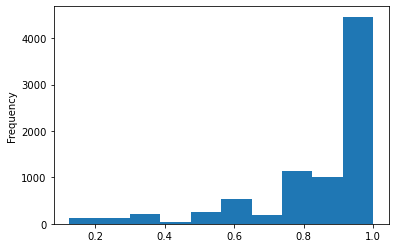

In [87]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [88]:
OA_percentile_df

33rd      66th   med_high   med_low      diff
ECHAM-SALSA   0.647283  1.429630   2.432975  0.397672  0.782347
NorESM        4.694496  7.745166  10.434747  3.360543  3.050669
EC-Earth      2.835946  3.471395   3.993794  2.499756  0.635449
Observations  0.598793  1.084997   1.525113  0.415000  0.486205

## Quantile cut

In [89]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [90]:
palette = 'Set2'

In [91]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

In [92]:
for key in dic_df.keys():
    _df = dic_df[key].copy()
    #_df = _df[_df[v_x]<x_cut]
    print(key)
    print(len(_df.dropna().reset_index()['time'].unique()))
    #_df.reset_index()['time'].unique().plot()

ECHAM-SALSA
426
NorESM
389
EC-Earth
412
Observations
64


3169
Plots/dist_plot/cloud_props_distribution_mod_obs_COT_count_MAM.png


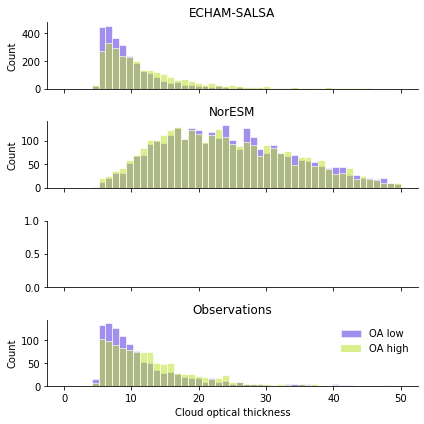

In [93]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_bins = np.linspace(0,50)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    if key=='EC-Earth':
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins=_bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



3138
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


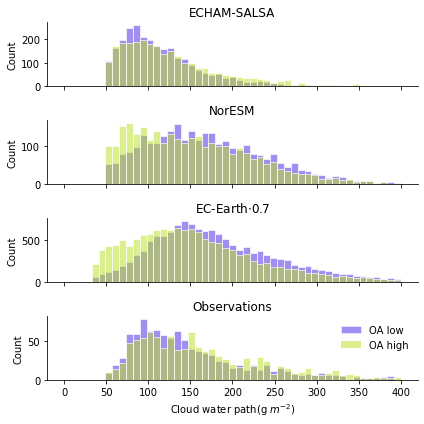

In [94]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,400)
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1038
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


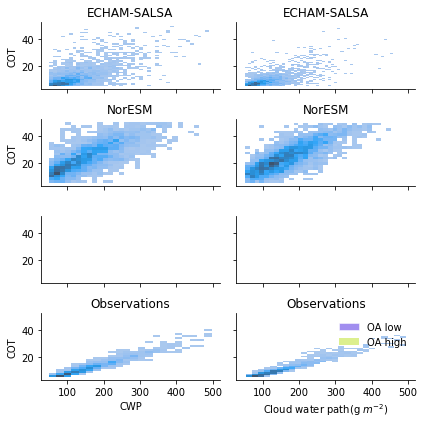

In [95]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    if key=='EC-Earth':
        continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1038
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


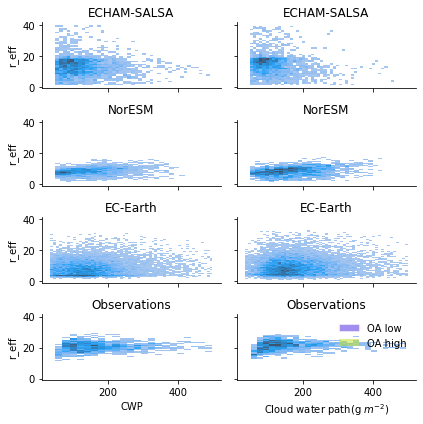

In [96]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'r_eff'
x_cut = 500
y_cut = 40
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    #if key=='EC-Earth':
    #    continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_y]<y_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [97]:
hue_v = 'OA high'

3138
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


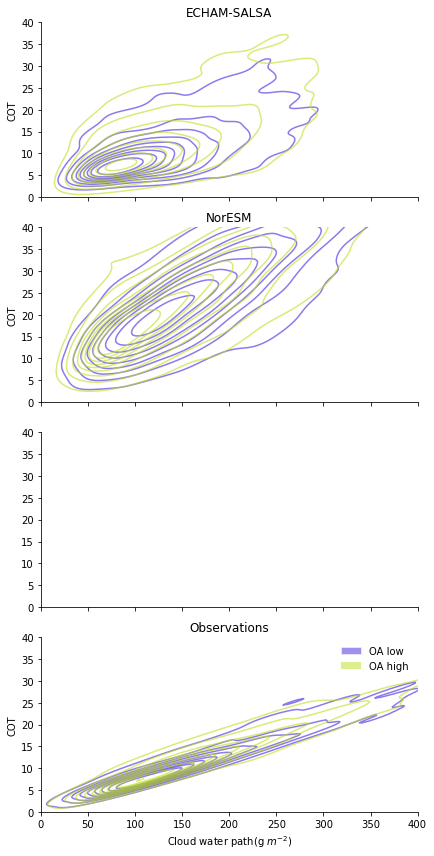

In [98]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key=='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,40])    

3169
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_MAM.png


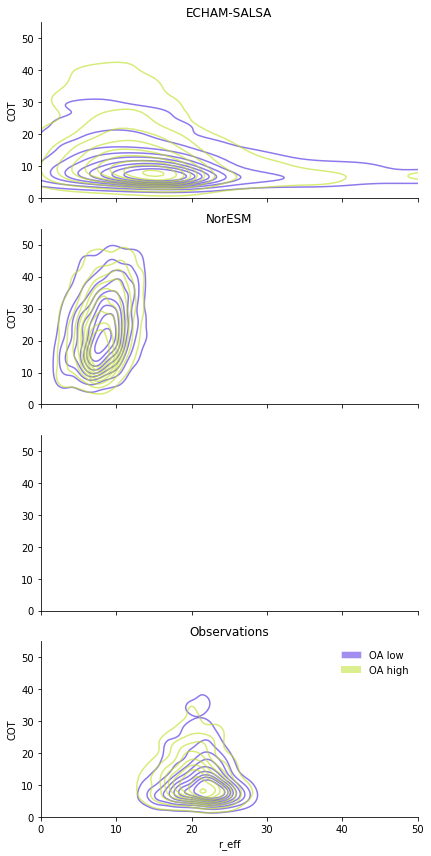

In [99]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'r_eff'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key =='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel(v_x)
ax.set_ylabel(v_y)

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,50])
    ax.set_ylim([0,55])    

3138
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


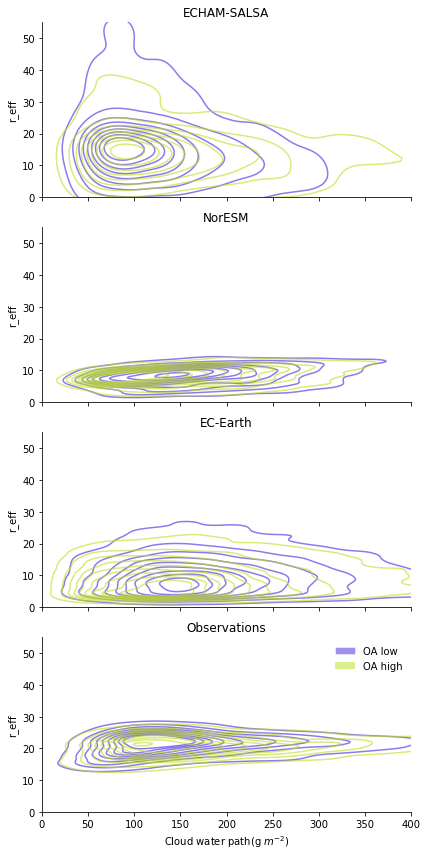

In [100]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_y = 'r_eff'
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

# fig.savefig(fn, dpi=150)
fig.tight_layout()
# fig.savefig(fn, dpi=150)
# fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,55])    

<AxesSubplot:ylabel='Frequency'>

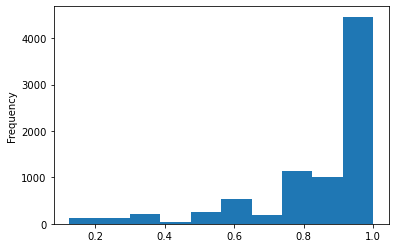

In [101]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [102]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

8117

In [103]:
len(dic_df['ECHAM-SALSA'])

8117

In [104]:
len(dic_df['NorESM'].dropna())

5969

8117
8975
42363
3169
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_MAM.png


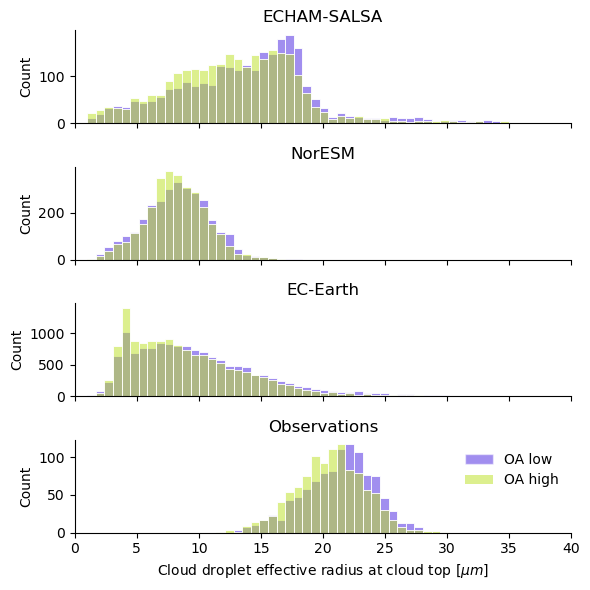

In [105]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
_bins = np.linspace(1, 35)
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        bins = _bins,
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [106]:
dic_df[model_name_echam]

station  lcdnc_ct_cm3      lcdnc_ct  cod_incld  \
time       lat       lon                                                      
2012-03-01 -2.797890 294.375    ATTO     11.517762  1.151776e+07   9.730782   
                     296.250    ATTO     12.082354  1.208235e+07   5.477490   
                     300.000    ATTO      1.301715  1.301715e+06  10.303343   
                     301.875    ATTO      0.593582  5.935822e+05   8.521373   
                     303.750    ATTO      0.514841  5.148411e+05  11.104119   
...                              ...           ...           ...        ...   
2018-05-31 -2.797890 298.125    ATTO      1.877004  1.877004e+06   5.116022   
                     301.875    ATTO      2.755321  2.755321e+06   5.620202   
           -4.663150 298.125    ATTO      3.339521  3.339521e+06   6.794694   
                     303.750    ATTO    114.580880  1.145809e+08  12.127717   
           -6.528409 307.500    ATTO     44.569847  4.456985e+07  12.150103   

                                     lcdnc         cwp  clfr  tempair_ct  \
time       lat       lon                                                   
2012-03-01 -2.797890 294.375  3.659215e-29  196.359590   0.0   278.98807   
                     296.250  4.430445e-29   88.272570   0.0   282.87240   
                     300.000  2.426875e-29  114.584870   0.0   276.29666   
                     301.875 -2.671051e-29   85.055740   0.0   267.30865   
                     303.750  2.757007e-29  124.432724   0.0   263.80786   
...                                    ...         ...   ...         ...   
2018-05-31 -2.797890 298.125  8.532191e-29   64.214160   0.0   280.83405   
                     301.875  7.492583e-29   77.383790   0.0   285.53452   
           -4.663150 298.125  1.128593e-28   92.471730   0.0   283.18707   
                     303.750  7.613257e-29   65.151375   0.0   274.96735   
           -6.528409 307.500  9.468250e-29   84.103260   0.0   283.24900   

                                    COT  cl_time_ct  ...  OA_category  \
time       lat       lon                             ...                
2012-03-01 -2.797890 294.375   9.730782      0.8750  ...         <NA>   
                     296.250   5.477490      0.6250  ...         <NA>   
                     300.000  10.303343      1.0000  ...         <NA>   
                     301.875   8.521373      0.7500  ...         <NA>   
                     303.750  10.397937      0.2500  ...         <NA>   
...                                 ...         ...  ...          ...   
2018-05-31 -2.797890 298.125   5.116022      1.0000  ...         <NA>   
                     301.875   5.620202      0.8125  ...         <NA>   
           -4.663150 298.125   6.794694      1.0000  ...         <NA>   
                     303.750  12.127717      1.0000  ...         <NA>   
           -6.528409 307.500  12.150103      1.0000  ...         <NA>   

                                 CWP_cut  CWP_cutl  CWP_cutlm  \
time       lat       lon                                        
2012-03-01 -2.797890 294.375  (170, 200]     185.0        184   
                     296.250   (80, 110]      95.0         95   
                     300.000  (110, 140]     125.0        124   
                     301.875   (80, 110]      95.0         95   
                     303.750  (110, 140]     125.0        124   
...                                  ...       ...        ...   
2018-05-31 -2.797890 298.125    (50, 80]      65.0         68   
                     301.875    (50, 80]      65.0         68   
           -4.663150 298.125   (80, 110]      95.0         95   
                     303.750    (50, 80]      65.0         68   
           -6.528409 307.500   (80, 110]      95.0         95   

                                                      CWP_cut2  CWP_cut2l  \
time       lat       lon                                                    
2012-03-01 -2.797890 294.375   (181.00363, 207.20359799999997]

df_ec_earth = dic_df['EC-Earth']
df_ec_earth = df_ec_earth[df_ec_earth['r_eff']>=5]
dic_df['EC-Earth'] = df_ec_earth

<AxesSubplot:ylabel='Frequency'>

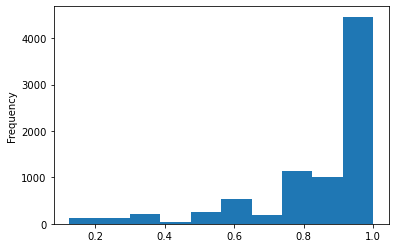

In [107]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [108]:
ds_ech = dic_df['ECHAM-SALSA'].to_xarray()

In [109]:
ds_nor = dic_df['NorESM'].to_xarray()

In [110]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-03-01 2012-03-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object nan nan nan 'ATTO' ... nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    lcdnc_ct        (time, lat, lon) float64 nan nan nan ... nan nan nan
    cod_incld       (time, lat, lon) float64 nan nan nan 13.39 ... nan nan nan
    lcdnc           (time, lat, lon) float64 nan nan nan ... nan nan nan
    cwp             (time, lat, lon) float64 nan nan nan 75.2 ... nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_cut2l       (time, lat, lon) float64 nan nan nan 0.0 ... 1.0 nan nan nan
    CWP_cut2lm      (time, lat, lon) float64 nan nan nan 65.0 ... nan nan nan
    CWP_cut2lmid    (time, lat, lon) float64 nan nan nan 38.0 ... nan nan nan
    CWP_qcut        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_qcutl       (time, lat, lon) float64 nan nan nan 80.89 ... nan nan nan

In [111]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-03-01 2012-03-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object nan nan nan 'ATTO' ... nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    lcdnc_ct        (time, lat, lon) float64 nan nan nan ... nan nan nan
    cod_incld       (time, lat, lon) float64 nan nan nan 13.39 ... nan nan nan
    lcdnc           (time, lat, lon) float64 nan nan nan ... nan nan nan
    cwp             (time, lat, lon) float64 nan nan nan 75.2 ... nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_cut2l       (time, lat, lon) float64 nan nan nan 0.0 ... 1.0 nan nan nan
    CWP_cut2lm      (time, lat, lon) float64 nan nan nan 65.0 ... nan nan nan
    CWP_cut2lmid    (time, lat, lon) float64 nan nan nan 38.0 ... nan nan nan
    CWP_qcut        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_qcutl       (time, lat, lon) float64 nan nan nan 80.89 ... nan nan nan

In [112]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-03-01 2012-03-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object nan nan nan 'ATTO' ... nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    lcdnc_ct        (time, lat, lon) float64 nan nan nan ... nan nan nan
    cod_incld       (time, lat, lon) float64 nan nan nan 13.39 ... nan nan nan
    lcdnc           (time, lat, lon) float64 nan nan nan ... nan nan nan
    cwp             (time, lat, lon) float64 nan nan nan 75.2 ... nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_cut2l       (time, lat, lon) float64 nan nan nan 0.0 ... 1.0 nan nan nan
    CWP_cut2lm      (time, lat, lon) float64 nan nan nan 65.0 ... nan nan nan
    CWP_cut2lmid    (time, lat, lon) float64 nan nan nan 38.0 ... nan nan nan
    CWP_qcut        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_qcutl       (time, lat, lon) float64 nan nan nan 80.89 ... nan nan nan

In [113]:
ds_nor['COT'].count()

<xarray.DataArray 'COT' ()>
array(8975)

In [114]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-03-01 2012-03-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/64)
    station         (time, lat, lon) object nan nan nan 'ATTO' ... nan nan nan
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    lcdnc_ct        (time, lat, lon) float64 nan nan nan ... nan nan nan
    cod_incld       (time, lat, lon) float64 nan nan nan 13.39 ... nan nan nan
    lcdnc           (time, lat, lon) float64 nan nan nan ... nan nan nan
    cwp             (time, lat, lon) float64 nan nan nan 75.2 ... nan nan nan
    ...              ...
    CWP_cut2        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_cut2l       (time, lat, lon) float64 nan nan nan 0.0 ... 1.0 nan nan nan
    CWP_cut2lm      (time, lat, lon) float64 nan nan nan 65.0 ... nan nan nan
    CWP_cut2lmid    (time, lat, lon) float64 nan nan nan 38.0 ... nan nan nan
    CWP_qcut        (time, lat, lon) object nan nan nan ... nan nan nan
    CWP_qcutl       (time, lat, lon) float64 nan nan nan 80.89 ... nan nan nan

<AxesSubplot:ylabel='Frequency'>

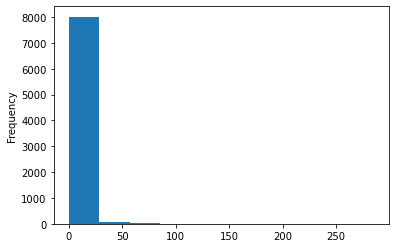

In [115]:
dic_df[model_name_echam]['lcdnc_cm3'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

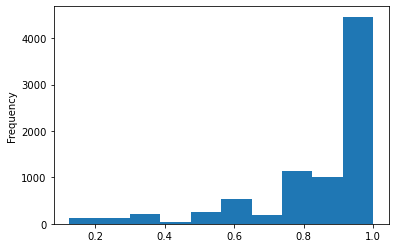

In [116]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

# Calculate difference between high OA and low


In [117]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [118]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [119]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [120]:
from sklearn.utils import resample

## Bootstrap resampling 

In [121]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [122]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations = 1000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key =='EC-Earth') and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
426
length of 65 is 549 and 534
number of days is 183 and 210
1000
length of 89 is 758 and 613
number of days is 187 and 211
1000
length of 115 is 533 and 496
number of days is 181 and 202
1000
length of 140 is 366 and 359
number of days is 164 and 173
1000
length of 166 is 188 and 219
number of days is 113 and 120
1000
length of 193 is 128 and 161
number of days is 89 and 107
1000
length of 244 is 180 and 321
number of days is 101 and 147
1000
NorESM
Total number of days:
389
length of 70 is 322 and 576
number of days is 127 and 129
1000
length of 103 is 479 and 555
number of days is 163 and 151
1000
length of 137 is 596 and 514
number of days is 167 and 152
1000
length of 172 is 525 and 456
number of days is 157 and 140
1000
length of 207 is 419 and 378
number of days is 149 and 127
1000
length of 241 is 301 and 241
number of days is 134 and 100
1000
length of 294 is 348 and 259
number of days is 133 and 109
1000
EC-Earth
Observations
Total number of

In [123]:
v = 'COT'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
1.1339240602775205
NorESM
1.0795316691238075
Observations
0.42905106829511147


In [124]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
Observations


# Final plot: 

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_MAM.png


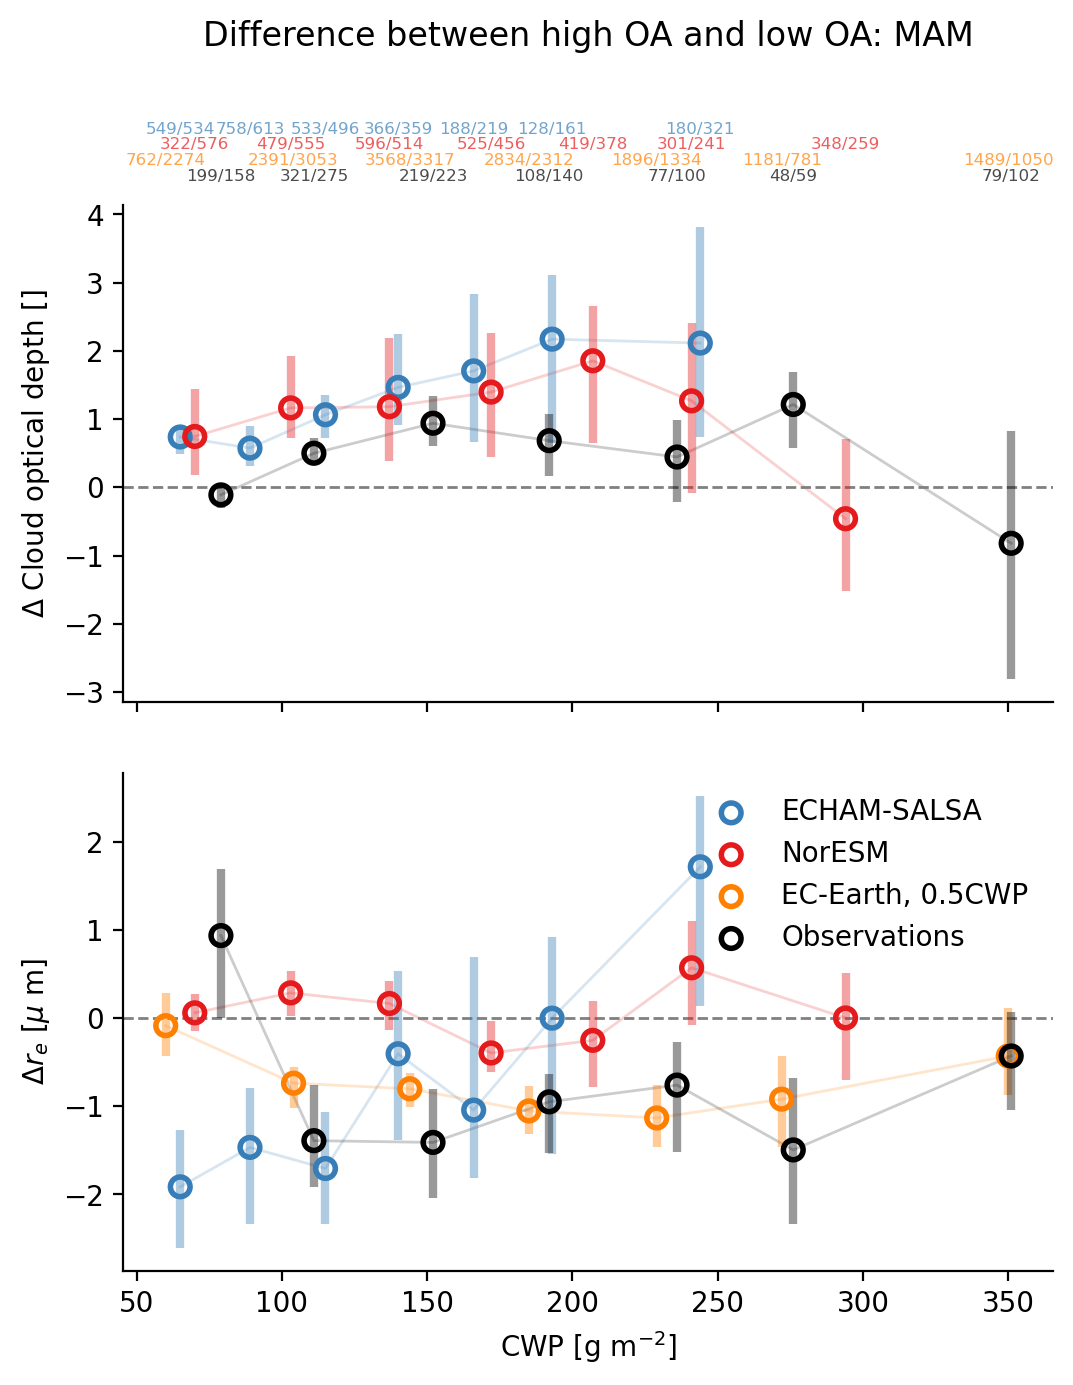

In [125]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in dic_df.keys():
        if (key=='EC-Earth') and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        if key=='EC-Earth':
            label = f'{key}, 0.5CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_MAM.png


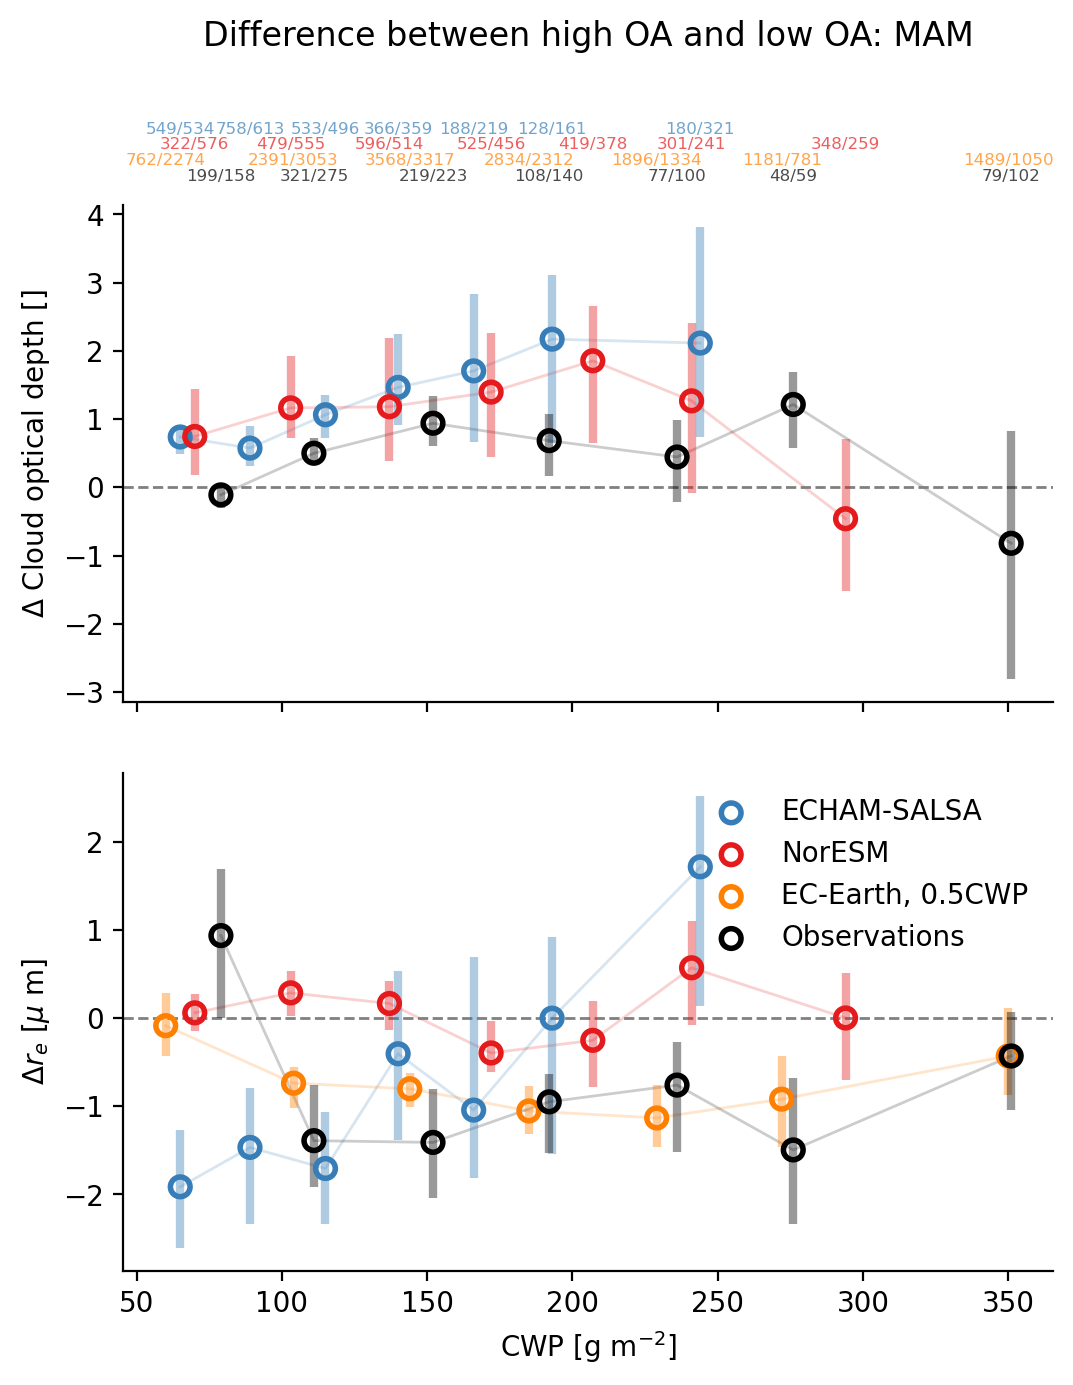

In [126]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in dic_df.keys():
        if (key=='EC-Earth') and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        if key=='EC-Earth':
            label = f'{key}, 0.5CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [127]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [128]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_MAM.png


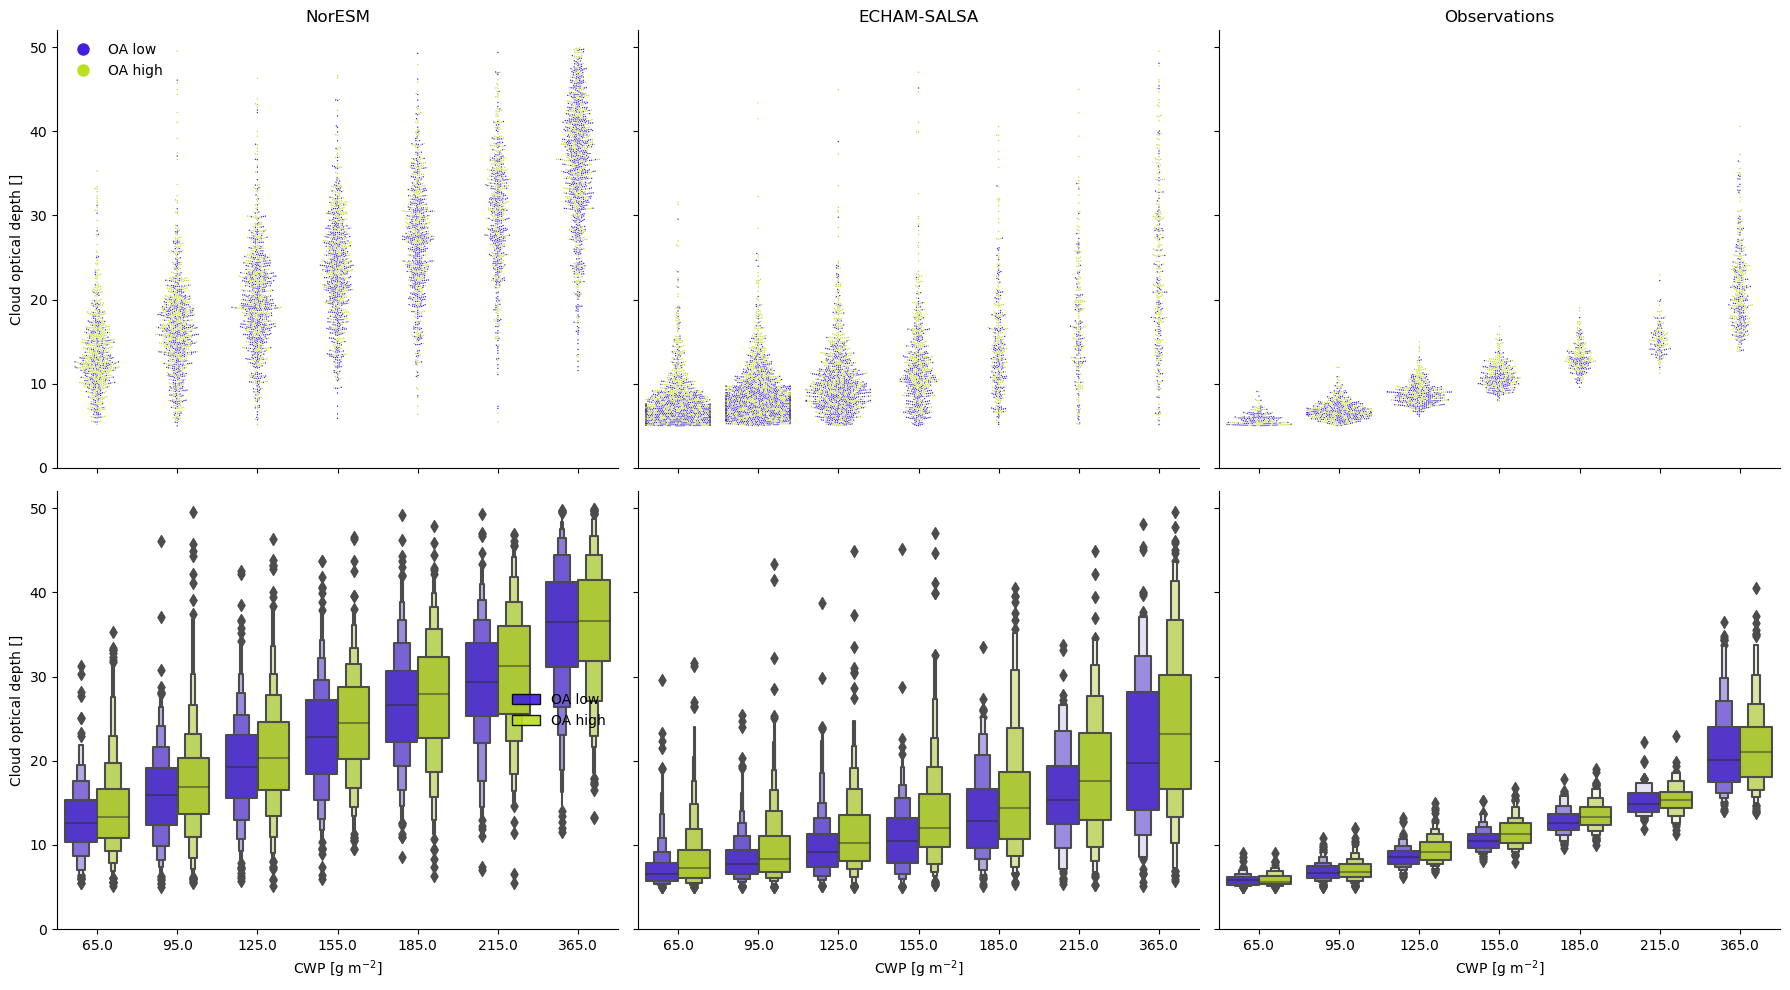

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_MAM.png


In [129]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 1



for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_MAM.png


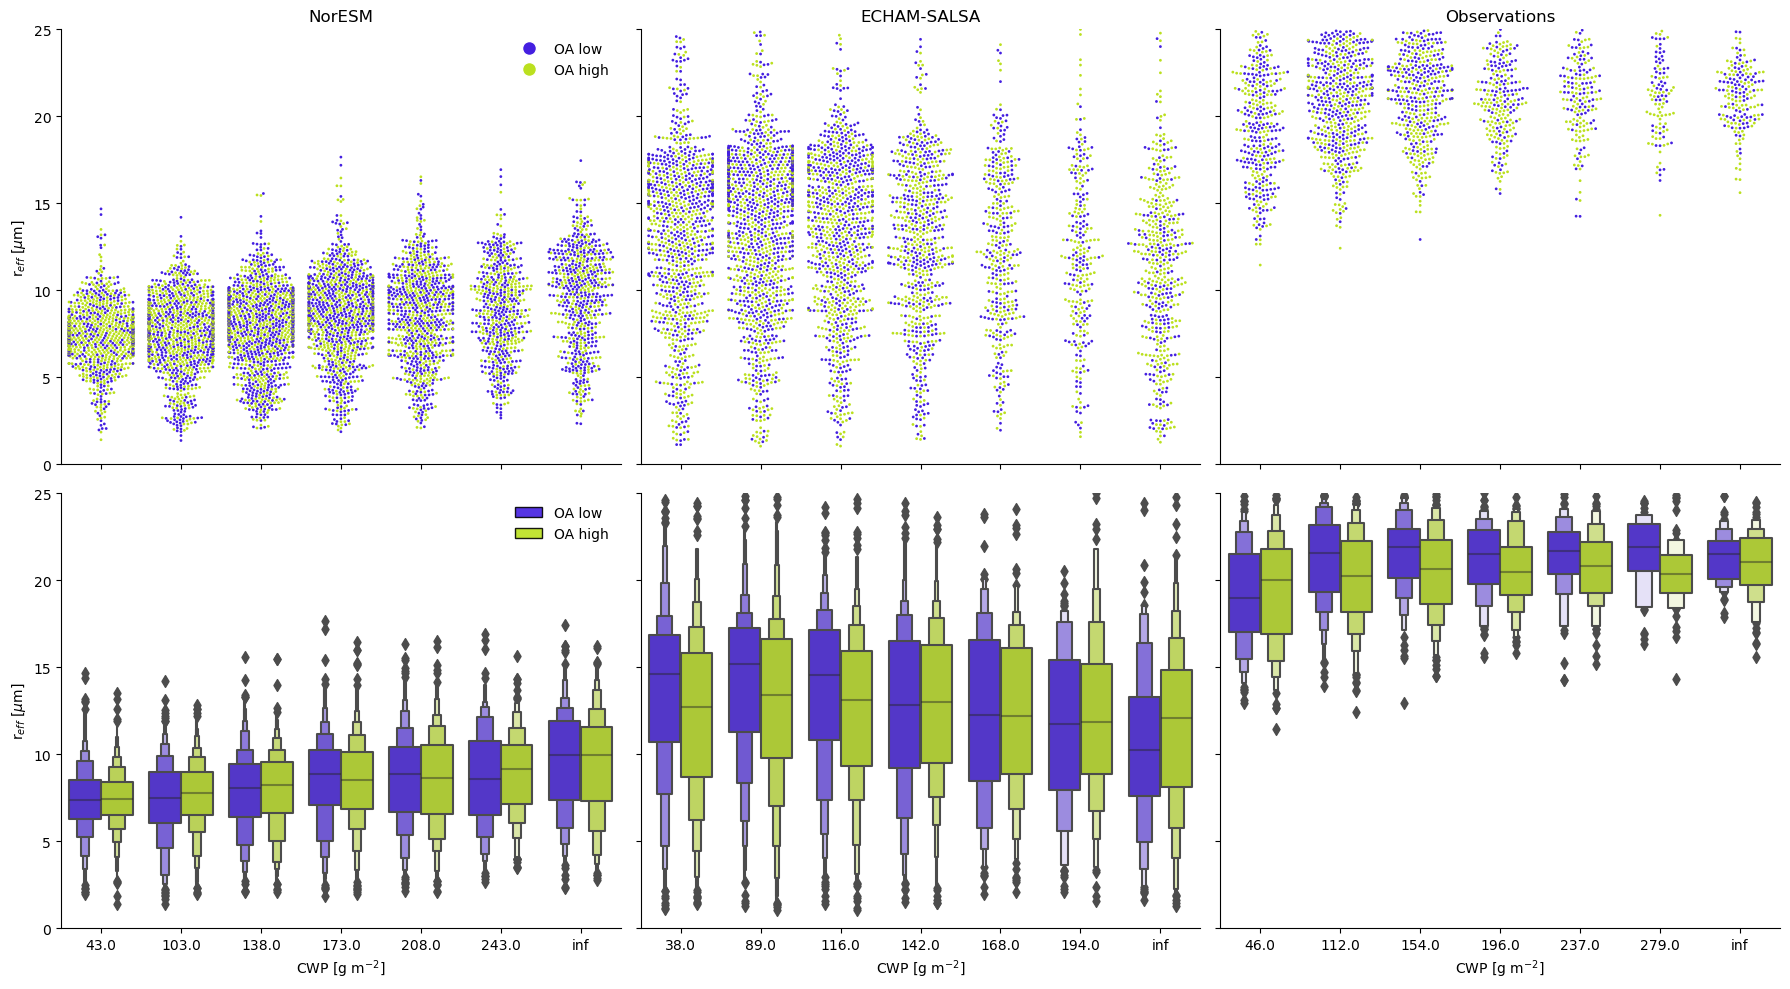

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_MAM.png


In [130]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_MAM.png


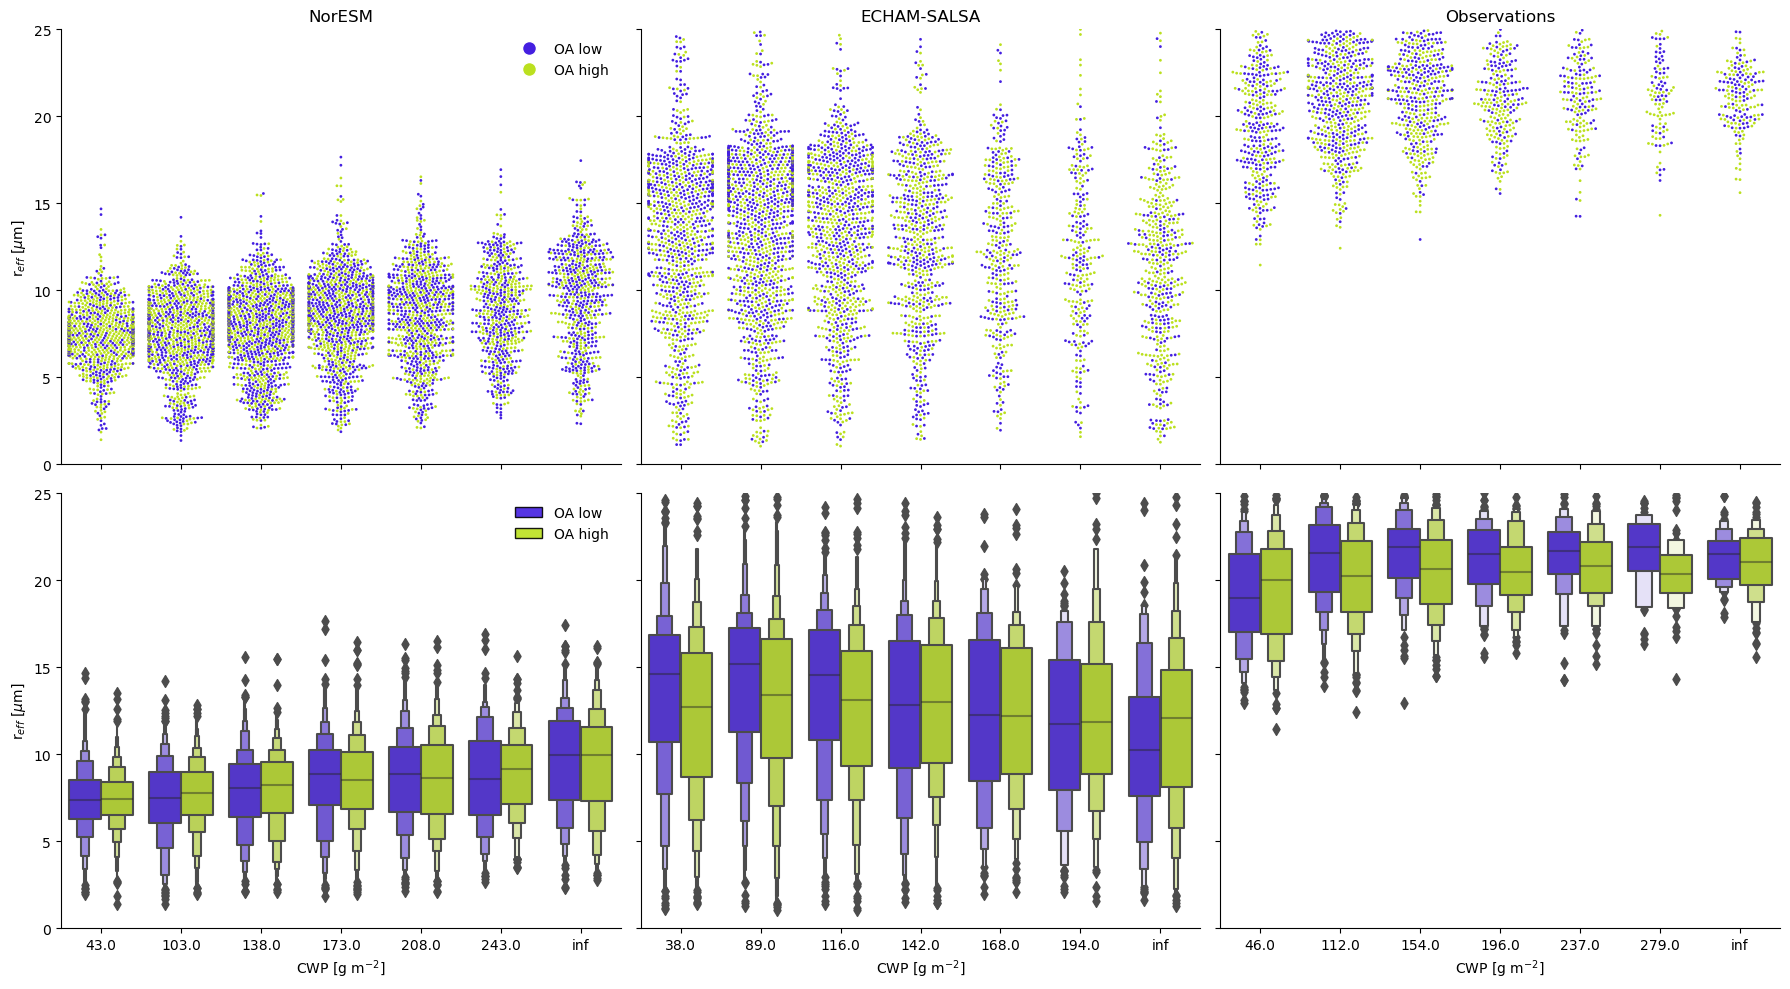

In [131]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

length of 68 is 668 and 614
number of days is 185 and 213
10000
length of 95 is 804 and 693
number of days is 189 and 215
10000
length of 124 is 545 and 509
number of days is 181 and 197
10000
length of 152 is 310 and 332
number of days is 150 and 161
10000
length of 184 is 162 and 201
number of days is 95 and 121
10000
length of 213 is 94 and 146
number of days is 72 and 93
10000
length of 262 is 116 and 207
number of days is 73 and 114
10000


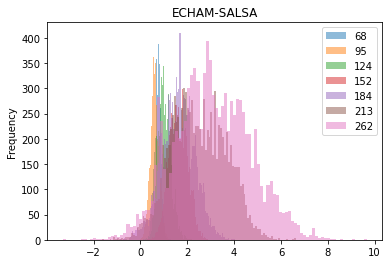

length of 68 is 254 and 481
number of days is 118 and 123
10000
length of 96 is 401 and 495
number of days is 153 and 141
10000
length of 126 is 498 and 456
number of days is 156 and 148
10000
length of 155 is 467 and 416
number of days is 163 and 142
10000
length of 184 is 430 and 364
number of days is 152 and 126
10000
length of 214 is 326 and 300
number of days is 133 and 121
10000
length of 266 is 614 and 467
number of days is 163 and 129
10000


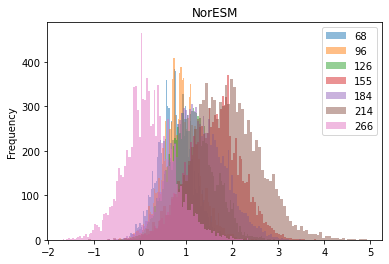

KeyError: 'COT'

In [132]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 10000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()